# Starbucks Capstone Challenge

## Preprocess data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import random
from functools import reduce

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
%matplotlib inline

# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

### portfolio

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


this dataframe consists of information about rewards, and luckily no unknown values exist.

In [4]:
portfolio.sort_values(by=['offer_type','difficulty','duration'])

,reward,channels,difficulty,duration,offer_type,id
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


this reward program provides 3 different offer types, bogo, discount, and informational.
- the bogo offer has two difficulty options, 5 and 10 bucks, and all bogo offers are sent via web, email, and mobile channels, but only ones with validity period of 5 days are sent via social channels.
- the discount offer has 3 difficulty options, 7, 10, and 20 bucks. The 20 bucks difficulty options offer is sent only via web and email, and the validity period of this is 10 days, and by completing this offer the customer will get 5 bucks as reward. The 10 bucks difficuty options consist of 2 distinct offers, one is sent via web, email, and mobile, and the validity period is 7 days; the other is sent via web, email, mobil, and social, and the validity period is 10 days; by completing either 10 bucks offer the customer will get 2 bucks as reward. The 7 bucks difficulty options offer is sent via web, email, mobile, and social, and the validity period is 7 days, and by completing it the customer will get 3 bucks as reward.
- there are 2 different informational offers, one is sent via email, mobile, and social channels, with a validity period of 3 days, the other is sent via email, mobile, and web channels, with a validity period of 4 days.

In [5]:
# rename id as offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# simplify offer_id
new_offer_ids = ['"offer_%s"'%str(s) for s in np.arange(1,11,1)]
portfolio['new_offer_id'] = new_offer_ids

offer_id_dict = dict(zip(portfolio.offer_id,portfolio.new_offer_id))
del portfolio['offer_id']

# split channels column
portfolio_explode = portfolio.explode('channels')
portfolio_channels = pd.get_dummies(portfolio_explode.channels, prefix='channels')
grouped_channels = portfolio_channels.groupby(portfolio_channels.index)[portfolio_channels.columns].sum()
portfolio = portfolio.join(grouped_channels, how='left').drop('channels', axis=1)

# change measurement of duration from day to hour
portfolio['duration_h'] = portfolio['duration'] * 24

portfolio

,reward,difficulty,duration,offer_type,new_offer_id,channels_email,channels_mobile,channels_social,channels_web,duration_h
0,10,10,7,bogo,"""offer_1""",1,1,1,0,168
1,10,10,5,bogo,"""offer_2""",1,1,1,1,120
2,0,0,4,informational,"""offer_3""",1,1,0,1,96
3,5,5,7,bogo,"""offer_4""",1,1,0,1,168
4,5,20,10,discount,"""offer_5""",1,0,0,1,240
5,3,7,7,discount,"""offer_6""",1,1,1,1,168
6,2,10,10,discount,"""offer_7""",1,1,1,1,240
7,0,0,3,informational,"""offer_8""",1,1,1,0,72
8,5,5,5,bogo,"""offer_9""",1,1,1,1,120
9,2,10,7,discount,"""offer_10""",1,1,0,1,168


### profile

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


there are unknown values in this dataframe, both in gender and income columns. Furthermore, the number of unknown values of gender is exactly the same as that of income, so I suspect that they belong to the same group of people.

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


- value None in gender column is same as NaN in income column
- age 118 is nearly impossible, so I might treat it as unknown value as well
- values in became_member_on column should be datetime type

#### gender

In [9]:
profile.gender.value_counts(dropna=False, normalize=True)

M      0.499059
F      0.360529
NaN    0.127941
O      0.012471
Name: gender, dtype: float64

In [10]:
# change dtype of gender from string to integer by
# Male->1
# Female->2
# Other->3
# unknown->4
profile.gender.replace({'M':1, 'F':2, 'O':3, np.nan:4}, inplace=True)

profile.gender.head()

0    4
1    2
2    4
3    2
4    4
Name: gender, dtype: int64

M is short for Male, F is short for Female, and O is short for Other, so NaN values and Other values should be treated as same values.

#### age

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

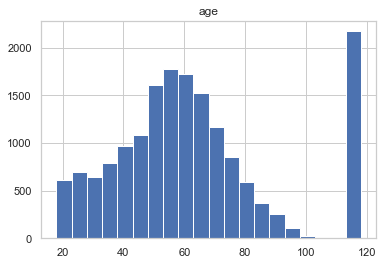

In [11]:
profile.hist('age', bins=20)
profile['age'].describe()

- minimum age is 18, which might be because this program is available only for adults
- more than 12% of people are at age 118, which is definitely impossible, so I guess it can be treated as NaN values

In [12]:
len(profile[profile.age==118])

2175

the number of people at age 118 is exactly the same as number of unknown values in columns of gender and income, do they belong to the same group of people?

In [13]:
print('unique gender: ',profile[profile.age==118]['gender'].unique())
print('unique income: ', profile[profile.age==118]['income'].unique())

unique gender:  [4]
unique income:  [nan]


so these 2175 people didn't input any information when registered, it's reasonable to add a column distincting them from others.

In [14]:
profile['is_mysterious'] = np.where((profile.age==118)&(profile.gender==4)&(profile.income.isnull()),1,0)
profile['is_mysterious'].value_counts()

0    14825
1     2175
Name: is_mysterious, dtype: int64

#### id

In [15]:
# rename id as member id
profile.rename(columns={'id':'member_id'}, inplace=True)

#### became_member_on

In [16]:
# change data type of became_member_on column from string to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore')

In [17]:
profile['became_member_on'].max()

Timestamp('2018-07-26 00:00:00')

the last person who enrolled in this program is on July 26th, 2018

In [18]:
# split into year, month, and day
profile['enrolled year'] = profile['became_member_on'].dt.year
profile['enrolled month'] = profile['became_member_on'].dt.month
profile['enrolled day'] = profile['became_member_on'].dt.day

In [19]:
# add a column calculating membership days of each customer
lastday = profile['became_member_on'].max()
profile['membership_days'] = profile['became_member_on'].apply(lambda x: (lastday - x).days + 24)

# add a column calculating membership months of each customer
profile['membership_months'] = profile['membership_days']/30

# delete became_member_on column
del profile['became_member_on']

#### income

<AxesSubplot:xlabel='membership_days'>

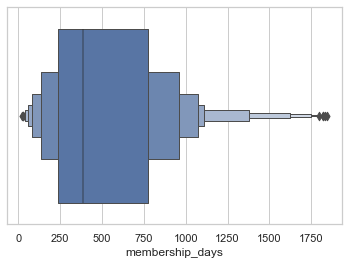

In [20]:
sns.boxenplot(x=profile[profile['age']==118]['membership_days'])

### transcript

In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


luckily no unknown values in this dataset

In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- values of the person column seems to be the same as the id column of profile dataframe, if this is the case, then I will rename person as member_id. 
- the value column contains dictionaries, so I will separate it into two columns by key and value. 
- I have not idea what the values in the time column represent, and I guess it is the time when the event happend.

#### person

In [24]:
# check if the person column are same as member_id column of profile dataset
overlap = set(profile.member_id) & set(transcript.person)
profile_overlap = float(len(overlap) / profile.member_id.nunique())
transcript_overlap = float(len(overlap) / transcript.person.nunique())

print('profile overlap', profile_overlap)
print('transcript overlap', transcript_overlap)

profile overlap 1.0
transcript overlap 1.0


all the member ids of profile dataset exist in person column of transcript dataset, so I will rename it as member_id as well

In [25]:
# change the column name from "person" to "member_id"
transcript.rename(columns={'person':'member_id'}, inplace=True)

#### event

In [26]:
transcript.event.value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

the reasonable order of events should be: offer received -> offer viewed -> offer completed, but other situationa may also happen. For example, someone might complete the offer without viewing it, or might view the offer after completing it. Therefore, we should take all situations into account.

#### value

In [27]:
transcript.value.sample(20)

108695    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
175294    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}
287734                                                 {'amount': 1.85}
81431                                                  {'amount': 0.65}
102453                                                 {'amount': 1.35}
104558                                                {'amount': 15.36}
288643                                                 {'amount': 9.05}
75998                  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
95336                  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
164046                 {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
148586                                                {'amount': 31.23}
304540                 {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
35689                  {'offer id': '3f207df678b143eea3cee63160fa8bed'}
294981                                                {'amount':

the value column contains many information, including transaction amount, offer id, and reward amount, so it might be better to extract those information and put them into separate columns

In [28]:
# split value column
transcript_value = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript_value], axis=1)
transcript.head()

,member_id,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


there are two similar column names: offer id and offer_id, are they the same?

In [29]:
transcript[transcript['offer id'].notnull()].head()

,member_id,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [30]:
transcript[transcript['offer_id'].notnull()].head()

,member_id,event,time,offer id,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [31]:
transcript[(transcript['offer id'].notnull())&(transcript['offer_id'].notnull())].head()

,member_id,event,time,offer id,amount,offer_id,reward


so offer id are recorded when offer is received, and offer_id is recorded when offer is completed, so it is reasonable to combine those two columns

In [32]:
# keep offer_id column and fillna with values of offer id column and delete offer id column
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)
del transcript['offer id']
transcript.head()

,member_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


#### time

In [33]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [34]:
transcript['time'].max()/30

23.8

the records on this file lasts about 24 days

#### add new_offer_id column and delete offer_id columns

In [35]:
transcript['new_offer_id'] = transcript['offer_id'].map(offer_id_dict)

del transcript['offer_id']

## Feature engineering

#### randomly select customers

In [36]:
random_person = random.choice(transcript['member_id'])
transcript[transcript['member_id']==random_person]

,member_id,event,time,amount,reward,new_offer_id
1462,6006641a7b15444fae1ae0a7e27a88dd,offer received,0,NaN,NaN,"""offer_5"""
46712,6006641a7b15444fae1ae0a7e27a88dd,transaction,126,19.49,NaN,NaN
54647,6006641a7b15444fae1ae0a7e27a88dd,offer received,168,NaN,NaN,"""offer_10"""
66246,6006641a7b15444fae1ae0a7e27a88dd,transaction,168,27.00,NaN,NaN
66247,6006641a7b15444fae1ae0a7e27a88dd,offer completed,168,NaN,5.0,"""offer_5"""
66248,6006641a7b15444fae1ae0a7e27a88dd,offer completed,168,NaN,2.0,"""offer_10"""
85487,6006641a7b15444fae1ae0a7e27a88dd,offer viewed,216,NaN,NaN,"""offer_10"""
112281,6006641a7b15444fae1ae0a7e27a88dd,offer received,336,NaN,NaN,"""offer_5"""
141793,6006641a7b15444fae1ae0a7e27a88dd,transaction,378,33.27,NaN,NaN
141794,6006641a7b15444fae1ae0a7e27a88dd,offer completed,378,NaN,5.0,"""offer_5"""


## Create new features

By checking the information above, I will add several new features. Before that, I will rearange the dataframe by matching all actions by offer.

#### create a dataframe containning receive, view, and complete time of each offer

In [37]:
time_dict = {}
time_list = ['receive','view','complete']

# create 3 dataframes containing time of "offer received", "offer viewed", and "offer completed", and rename them as
# "receive_time", "view_time", and "complete_time"
for t in time_list:
    time_dict[t] = transcript[transcript['event'].str.contains(t)][['member_id','new_offer_id','time']]\
                    .rename(columns={'time':'%s_time'%t}).set_index(['member_id','new_offer_id'])

# combine the 3 dataframes with three new columns created above, so that each offer of each customer has receive time,
# view time, and complete time on the same row. Since the 3 dataframes are outer combined on member_id and offer_id,
# if the offer was received, or viewed, or completed more than one time, then all possible combinations will be
# created, so I have to find the correct match and delete the rest
time_df = reduce(lambda x,y: pd.merge(x,y, on=['member_id','new_offer_id'], how='outer'), 
                 list(time_dict.values())).reset_index()

# add a column of duration of each offer, to check if the offer was viewed or completed within valid duration, if not,
# then it means that the combination of times is incorrect so the row should be deleted, or the value of time should
# be deleted and switched to NaN
duration_dict = dict(zip(portfolio.new_offer_id,portfolio.duration_h))
time_df['duration_h'] = time_df['new_offer_id'].map(duration_dict)

# create a list to calculate the time difference between receiving&viewing, receivign&completing, and 
# viewing&completing of each offer
time_list2 = [['receive','view'],['receive','complete'],['view','complete']]

# create a column calculating differences of pairs listed above
# if any value of the pair is NaN then the difference is NaN otherwise calculate the difference
for t in time_list2:
    time_df['%s_%s_diff'%(t[0],t[1])] = time_df.apply(lambda x: np.nan if np.isnan(x['%s_time'%t[0]])
                                                                       or np.isnan(x['%s_time'%t[1]]) 
                                                                else x['%s_time'%t[1]] - x['%s_time'%t[0]], axis=1) 
    
    # if time difference of receive&view or receive%complete is negative, which means the offer was viewed or 
    # completed before it was received, then that is impossible and the view time or complete time is incorrect and 
    # should be NaN
    if t[0]=='receive': 
        time_df['%s_time'%t[1]] = np.where(time_df['receive_%s_diff'%t[1]]>=0, time_df['%s_time'%t[1]], np.nan)
        
        time_df['receive_%s_diff'%t[1]] = np.where(time_df['%s_time'%t[1]].isnull(), np.nan, time_df['receive_%s_diff'%t[1]])

# sort values so the smallest difference or non-NaN values will be on top
time_df.sort_values(by=['member_id','new_offer_id','receive_time','view_time','complete_time'], inplace=True)
# if duplicated values exist, then drop larger differences or NaN values
time_df.drop_duplicates(subset=['member_id','new_offer_id','receive_time'], keep='first', inplace=True)

# till now the receive time column is clean, but view and complete column still contain duplicated values. We cannot
# simply drop all duplicated values, because it is possible that more than one offer can be viewed or completed within
# one hour, and there are records with same member_id, offer_id, and view of complete time, which means that the
# customer received two offers of same offer_id in different times, but completed both of them in one hour or even in
# one trasaction
for i in ['view','complete']:
    # count how many of offers by type each members viewed or completed in the original dataframe, and get the time
    # for example, customer A completed offer 1 in time 10 twice, and customer B completed offer 2 in time 5 3 times
    view_df = transcript[transcript['event'].str.contains(i)]
    view_cnt_real = view_df.groupby(['member_id','new_offer_id','time']).size()\
                    .to_frame(name='real_%s'%i)\
                    .reset_index()\
                    .rename(columns={'time':'%s_time'%i})
    
    # merge the count dataframe into time_df, so we know how many duplicates are allowed for each offer of each 
    # customer at each view time or complete time
    time_df = time_df.merge(view_cnt_real, on=['member_id','new_offer_id','%s_time'%i], how='left')
    # create a rank column, ranking how many duplicates are there for each offer of each customer at each time, and
    # order by time difference between view/complete and receive. So if maximum of 2 duplicates is allowed, then keep
    # the 2 with shortest time difference, and change the view time or complete time of the rest to NaN
    time_df['%s_rank'%i] = time_df.groupby(['member_id','new_offer_id','%s_time'%i])['receive_%s_diff'%i].rank()
    time_df['%s_time'%i] = np.where(time_df['%s_rank'%i]<=time_df['real_%s'%i], time_df['%s_time'%i], np.nan)

time_group = time_df.loc[:,['member_id','new_offer_id','receive_time','view_time','complete_time'
                           ,'receive_view_diff','receive_complete_diff','view_complete_diff'
                            ]]

time_group = time_group.merge(portfolio, on='new_offer_id', how='left')

time_group.head()

,member_id,new_offer_id,receive_time,view_time,complete_time,receive_view_diff,receive_complete_diff,view_complete_diff,reward,difficulty,duration,offer_type,channels_email,channels_mobile,channels_social,channels_web,duration_h
0,0009655768c64bdeb2e877511632db8f,"""offer_10""",576,NaN,576.0,NaN,0.0,NaN,2,10,7,discount,1,1,0,1,168
1,0009655768c64bdeb2e877511632db8f,"""offer_3""",336,372.0,NaN,36.0,NaN,NaN,0,0,4,informational,1,1,0,1,96
2,0009655768c64bdeb2e877511632db8f,"""offer_7""",504,540.0,528.0,36.0,24.0,-12.0,2,10,10,discount,1,1,1,1,240
3,0009655768c64bdeb2e877511632db8f,"""offer_8""",168,192.0,NaN,24.0,NaN,NaN,0,0,3,informational,1,1,1,0,72
4,0009655768c64bdeb2e877511632db8f,"""offer_9""",408,456.0,414.0,48.0,6.0,-42.0,5,5,5,bogo,1,1,1,1,120


In [38]:
def add_cols(cnt, full_cols):
    cols_to_add = list(set(full_cols) - set(cnt.columns))
    if cols_to_add:
        cnt = pd.concat([cnt,pd.DataFrame(columns=cols_to_add)])
    return cnt

def add_indices(cnt, full_indices):
    indices_to_add = list(set(full_indices)-set(cnt.index))
    if indices_to_add:
        df_to_add = pd.DataFrame(columns = cnt.columns, index=indices_to_add)
        cnt = cnt.append(df_to_add)
    return cnt

def num_cnt(orig_df, df, event, name=None):
    member_ids = orig_df['member_id'].unique().tolist()
    id_order = orig_df['new_offer_id'].unique().tolist()
    
    df_event = df[df['%s_time'%event].notnull()]
    # total
    total_cnt = df_event.groupby('member_id')['%s_time'%event].count().to_frame(name='total')
    # by type
    type_cnt = df_event.groupby(['member_id','offer_type']).size().unstack()
    type_cnt = add_cols(type_cnt, orig_df['offer_type'].unique())
    # by channel
    channel_list = orig_df.filter(like='channel').columns.tolist()
    channel_cnt = df_event.groupby(['member_id'])[channel_list].sum()
    channel_cnt.columns = channel_cnt.columns.str.replace('channels_','')
    # by id
    id_cnt = df_event.groupby(['member_id','new_offer_id']).size().unstack()
    id_cnt = add_cols(id_cnt, orig_df['new_offer_id'].unique())
    id_cnt = id_cnt[id_order]
    # concat
    cnt = pd.concat([total_cnt, type_cnt, channel_cnt, id_cnt], axis=1)
    if name==None:
        cnt = cnt.add_prefix('cnt_%s_'%event)
    else:
        cnt = cnt.add_prefix('cnt_%s_'%name)
        
    # check indices
    cnt = add_indices(cnt, member_ids)
    
    cnt.replace(0,np.nan,inplace=True)
    
    cnt.sort_index(inplace=True)
    
    return cnt

def pct(numerator, denominator, to_replace, names):
    
    pct = numerator.div(denominator.values)
    
    pct.columns = pct.columns.str.replace(to_replace,'')
    pct = pct.add_prefix('pct_%s/%s'%names)
    
    return pct

def ramt_sum(df, event, name=None):
    member_ids = df['member_id'].unique().tolist()
    
    df_event = df[df['%s_time'%event].notnull()]
    # total
    total_ramt = df_event.groupby('member_id')['reward'].sum().to_frame(name='total')
    
    # by type
    type_ramt = df_event.groupby(['member_id','offer_type'])['reward'].sum().unstack()
    type_ramt = add_cols(type_ramt, df['offer_type'].unique())
    # by channel
    channel_list = df.filter(like='channel').columns.tolist()
    channel_ramt_list = []
    for c in channel_list:
        channel_i = df[df[c]!=0]
        channel_i_ramt = channel_i.groupby('member_id')['reward'].sum().to_frame(name=c)
        channel_ramt_list.append(channel_i_ramt)
    channel_ramt = pd.concat(channel_ramt_list, axis=1)
    # by id
    id_ramt = df_event.groupby(['member_id','new_offer_id'])['reward'].sum().unstack()
    id_ramt = add_cols(id_ramt, df['new_offer_id'].unique())
    # concat
    ramt = pd.concat([total_ramt, type_ramt, channel_ramt, id_ramt], axis=1)
    if name==None:
        ramt = ramt.add_prefix('ramt_%s_'%event)
    else:
        ramt = ramt.add_prefix('ramt_%s_'%name)
        
    # check indices
    ramt = add_indices(ramt, member_ids)
    
    ramt.replace(0,np.nan,inplace=True)
    
    ramt.sort_index(inplace=True)
    
    return ramt

def time_calc(df, events):
    # total
    total = df.groupby('member_id').agg({'%s_%s_diff'%events:['max','min','mean']})
    total['total'] = 'total'
    total = total.set_index('total', append=True).unstack('total')
    # offer type
    by_type = df.groupby(['member_id','offer_type']).agg({'%s_%s_diff'%events:['max','min','mean']}).unstack()
    # channel
    channel_name_list = df.filter(like='channel').columns.tolist()
    channel_time_list = []
    for c in channel_name_list:
        channel_i = df[df[c]!=0]
        channel_i_time = channel_i.groupby('member_id').agg({'%s_%s_diff'%events:['max','min','mean']})
                                                       
        channel_i_time['channel'] = c.split('_')[1]
        channel_i_time = channel_i_time.set_index('channel', append=True).unstack('channel')
        channel_time_list.append(channel_i_time)
    by_channel = pd.concat(channel_time_list, axis=1)
    # offer id
    by_id = df.groupby(['member_id','new_offer_id']).agg({'%s_%s_diff'%events:['max','min','mean']}).unstack()
    
    # concat
    diff_group = pd.concat([total,by_type,by_channel,by_id],axis=1)
    diff_group.columns = ['_'.join(col) for col in diff_group.columns.values]
    
    return diff_group

- number of offers received
- number of offers received by type (bogo, discount, informational)
- number of offers received by channel (web, email, mobile, social)
- number of offers received by offer_id (10 ids)

In [39]:
receive_cnt = num_cnt(time_group, time_group, 'receive')

- number of offers viewed
- number of offers viewed by type
- number of offers viewed by channel
- number of offers viewed by offer_id

In [40]:
view_cnt = num_cnt(time_group, time_group, 'view')

- percentage of offers viewed (number viewed/number received)
- percentage of offers viewed by type
- percentage of offers viewed by channel
- percentage of offers viewed by offer_id

In [41]:
view_receive_pct = pct(view_cnt, receive_cnt,'cnt_view', ('view','receive'))

- number of offers completed
- number of offers completed by type
- number of offers completed by channel
- number of offers completed by offer_id

In [42]:
complete_cnt = num_cnt(time_group, time_group, 'complete')

- percentage of offers completed (number completed/number received)
- percentage of offers completed by type
- percentage of offers completed by channel
- percentage of offers completed by offer_id

In [43]:
complete_receive_pct = pct(complete_cnt, receive_cnt, 'cnt_complete', ('complete','receive'))

- number of offers completed without viewing 
- number of offers completed without viewing by type
- number of offers completed without viewing by channel
- number of offers completed without viewing by offer_id

In [44]:
cnt_df_cwv = time_group[(time_group['complete_time'].notnull())&(time_group['view_time'].isnull())]
complete_without_view_cnt = num_cnt(time_group, cnt_df_cwv, 'complete', name='cwv')

- percentage of offers completed without viewing (number of offers completed without view / number of offers completed)
- percentage of offers completed without viewing by type
- percentage of offers completed without viewing by channel
- percentage of offers completed without viewing by offer_id

In [45]:
cwv_complete_pct = pct(complete_without_view_cnt, complete_cnt, 'cnt_cwv', ('cwv','complete'))

- number of offers viewed after completed
- number of offers viewed after completed by type
- number of offers viewed after completed by channel
- number of offers viewed after completed by offer_id

In [46]:
cnt_df_vac = time_group[(time_group['complete_time'].notnull())
                        &(time_group['view_time'].notnull())
                        &(time_group['complete_time']<time_group['view_time'])]
view_after_complete_cnt = num_cnt(time_group, cnt_df_vac, 'complete', name='vac')

- percentage of offers viewed after completed (number of offers view after complete / number of offers view)
- percentage of offers viewed after completed by type
- percentage of offers viewed after completed by channel
- percentage of offers viewed after completed by offer_id

In [47]:
vac_view_pct = pct(view_after_complete_cnt, view_cnt, 'cnt_vac', ('vac','view'))

- max/min/average hours between receiving and viewing offers
- max/min/average hours between receiving and viewing offers by type
- max/min/average hours between receiving and viewing offers by channel
- max/min/average hours between receiving and viewing offers by offer_id

In [48]:
hrs_rv = time_calc(time_group, ('receive','view'))

- max/min/average hours between receiving and completing offers
- max/min/average hours between receiving and completing offers by type
- max/min/average hours between receiving and completing offers by channel
- max/min/average hours between receiving and completing offers by offer_id

In [49]:
hrs_rc = time_calc(time_group, ('receive','complete'))

- amount of reward offered
- amount of reward offered by type
- amount of reward offered by channel
- amount of reward offered by offer_id

In [50]:
reward_receive_amt = ramt_sum(time_group, 'receive')

- amount of reward viewed
- amount of reward viewed by type
- amount of reward viewed by channel
- amount of reward viewed by offer_id

In [51]:
reward_view_amt = ramt_sum(time_group, 'view')

- amount of reward completed
- amount of reward completed by type
- amount of reward completed by channel
- amount of reward completed by offer_id

In [52]:
reward_complete_amt = ramt_sum(time_group, 'complete')

- percentage of reward complete_receive (amount of reward complete / amount of reward receive)
- percentage of reward complete_receive by type
- percentage of reward complete_receive by channel
- percentage of reward complete_receive by offer_id

In [53]:
reward_complete_receive_pct = pct(reward_complete_amt, reward_receive_amt, 'ramt_complete', ('complete','receive_reward'))

- percentage of reward complete_view (amount of reward complete / amount of reward view)
- percentage of reward complete_view by type
- percentage of reward complete_view by type
- percentage of reward complete_view by offer_id

In [54]:
reward_complete_view_pct = pct(reward_complete_amt, reward_view_amt, 'ramt_complete', ('complete','view_reward'))

#### concat cnt_dfs

In [55]:
cnt_group = pd.concat([receive_cnt,view_cnt,complete_cnt,complete_without_view_cnt,view_after_complete_cnt], axis=1)

#### concat pct_dfs

In [56]:
pct_group = pd.concat([view_receive_pct,complete_receive_pct,cwv_complete_pct,vac_view_pct], axis=1)

#### concat hr_dfs

In [57]:
hr_group = pd.concat([hrs_rv, hrs_rc], axis=1)

#### concat reward_dfs

In [58]:
reward_group = pd.concat([reward_receive_amt,reward_view_amt,reward_complete_amt,
                        reward_complete_receive_pct,reward_complete_view_pct], axis=1)

- total number of transactions
- number of transactions after each
- number of transactions after each channel
- number of transactions after each offer_id

- total money spent
- total money spent after viewing offers
- total money spent after viewing offers by type
- total money spent after viewing offers by channel
- total money spent after viewing offers by offer_id

- average money spent after viewing each offer
- average money spent after viewing each offer by type
- average money spent after viewing each offer by channel
- average money spent after viewing each offer by offer_id

- maximum money spent after viewing each offer
- maximum money spent after viewing each offer by type
- maximum money spent after viewing each offer by channel
- maximum money spent after viewing each offer by offer_id

- minimum money spent after viewing each offer
- minimum money spent after viewing each offer by type
- minimum money spent after viewing each offer by channel
- minimum money spent after viewing each offer by offer_id

In [59]:
# get all records about offer viewed and transactions
view_trans_df = transcript[transcript['event'].str.contains('view|trans')]\
                [['member_id', 'event', 'new_offer_id', 'time', 'amount']].sort_values(by=['member_id','time'])

# add view_time columns that contains only time of offer viewed, and value of transactions row is empty
view_trans_df['view_time'] = np.where(view_trans_df['event'].str.contains('view'), view_trans_df['time'], np.nan)

# fill view_time of transactions with values above, so that we know this transactions took place after viewing which
# offer. If a transactions happened before viewing any offer, then the view_time of this transaction is NaN
view_trans_df[['new_offer_id','view_time']] = view_trans_df.groupby('member_id')[['new_offer_id','view_time']].ffill()

# only keep transactions and rename time as trans_time, so there is a trans_time, and a view_time column
trans_df = view_trans_df[view_trans_df['event'].str.contains('trans')].rename(columns={'time':'trans_time'})

# add a column calculating how many hours is the transaction after viewing the offer
trans_df['view_trans_hrs_diff'] = trans_df['trans_time'] - trans_df['view_time']

# merge portfolio
trans_df = trans_df.merge(portfolio, on='new_offer_id', how='left')

# group_total
trans_group_total = trans_df.groupby(['member_id'])\
                            .agg({
                                  'amount':['sum','mean','max','min']
                                 ,'view_trans_hrs_diff':['mean','max','min']
                                 ,'event':'count'
                                 })\
                            .rename(columns={'event':'trans','amount':'mamt'})

trans_group_total['total'] = 'total'
trans_group_total = trans_group_total.set_index('total', append=True).unstack('total')

# group_by_type
trans_group_by_type = trans_df.groupby(['member_id','offer_type'])\
                              .agg({
                                    'amount':['sum','mean','max','min']
                                   ,'view_trans_hrs_diff':['mean','max','min']
                                   ,'event':'count'
                                   })\
                              .rename(columns={'event':'trans','amount':'mamt'})\
                              .unstack()

# group_by_channel
channel_list = trans_df.filter(like='channel').columns.tolist()
channel_mamt_list = []
for c in channel_list:
    channel_i = trans_df[trans_df[c]!=0]
    channel_i_mamt = channel_i.groupby('member_id').agg({
                                                         'amount':['sum','mean','max','min']
                                                        ,'view_trans_hrs_diff':['mean','max','min']
                                                        ,'event':'count'
                                                        })\
                                                   .rename(columns={'event':'trans','amount':'mamt'})
    channel_i_mamt['channel'] = c.split('_')[1]
    channel_i_mamt = channel_i_mamt.set_index('channel', append=True).unstack('channel')
    channel_mamt_list.append(channel_i_mamt)
trans_group_by_channel = pd.concat(channel_mamt_list, axis=1)

# group_by_id
trans_group_by_id = trans_df.groupby(['member_id','new_offer_id'])\
                              .agg({
                                    'amount':['sum','mean','max','min']
                                   ,'view_trans_hrs_diff':['mean','max','min']
                                   ,'event':'count'
                                   })\
                              .rename(columns={'event':'trans','amount':'mamt'})\
                              .unstack()

# merge
trans_group = pd.concat([trans_group_total,trans_group_by_type,trans_group_by_channel,trans_group_by_id],axis=1)
trans_group.columns = ['_'.join(col) for col in trans_group.columns.values]

trans_group.head()

,mamt_sum_total,mamt_mean_total,mamt_max_total,mamt_min_total,view_trans_hrs_diff_mean_total,view_trans_hrs_diff_max_total,view_trans_hrs_diff_min_total,trans_count_total,mamt_sum_bogo,mamt_sum_discount,mamt_sum_informational,mamt_mean_bogo,mamt_mean_discount,mamt_mean_informational,mamt_max_bogo,mamt_max_discount,mamt_max_informational,mamt_min_bogo,mamt_min_discount,mamt_min_informational,view_trans_hrs_diff_mean_bogo,view_trans_hrs_diff_mean_discount,view_trans_hrs_diff_mean_informational,view_trans_hrs_diff_max_bogo,view_trans_hrs_diff_max_discount,view_trans_hrs_diff_max_informational,view_trans_hrs_diff_min_bogo,view_trans_hrs_diff_min_discount,view_trans_hrs_diff_min_informational,trans_count_bogo,trans_count_discount,trans_count_informational,mamt_sum_email,mamt_mean_email,mamt_max_email,mamt_min_email,view_trans_hrs_diff_mean_email,view_trans_hrs_diff_max_email,view_trans_hrs_diff_min_email,trans_count_email,mamt_sum_mobile,mamt_mean_mobile,mamt_max_mobile,mamt_min_mobile,view_trans_hrs_diff_mean_mobile,view_trans_hrs_diff_max_mobile,view_trans_hrs_diff_min_mobile,trans_count_mobile,mamt_sum_social,mamt_mean_social,mamt_max_social,mamt_min_social,view_trans_hrs_diff_mean_social,view_trans_hrs_diff_max_social,view_trans_hrs_diff_min_social,trans_count_social,mamt_sum_web,mamt_mean_web,mamt_max_web,mamt_min_web,view_trans_hrs_diff_mean_web,view_trans_hrs_diff_max_web,view_trans_hrs_diff_min_web,trans_count_web,"mamt_sum_""offer_1""","mamt_sum_""offer_10""","mamt_sum_""offer_2""","mamt_sum_""offer_3""","mamt_sum_""offer_4""","mamt_sum_""offer_5""","mamt_sum_""offer_6""","mamt_sum_""offer_7""","mamt_sum_""offer_8""","mamt_sum_""offer_9""","mamt_mean_""offer_1""","mamt_mean_""offer_10""","mamt_mean_""offer_2""","mamt_mean_""offer_3""","mamt_mean_""offer_4""","mamt_mean_""offer_5""","mamt_mean_""offer_6""","mamt_mean_""offer_7""","mamt_mean_""offer_8""","mamt_mean_""offer_9""","mamt_max_""offer_1""","mamt_max_""offer_10""","mamt_max_""offer_2""","mamt_max_""offer_3""","mamt_max_""offer_4""","mamt_max_""offer_5""","mamt_max_""offer_6""","mamt_max_""offer_7""","mamt_max_""offer_8""","mamt_max_""offer_9""","mamt_min_""offer_1""","mamt_min_""offer_10""","mamt_min_""offer_2""","mamt_min_""offer_3""","mamt_min_""offer_4""","mamt_min_""offer_5""","mamt_min_""offer_6""","mamt_min_""offer_7""","mamt_min_""offer_8""","mamt_min_""offer_9""","view_trans_hrs_diff_mean_""offer_1""","view_trans_hrs_diff_mean_""offer_10""","view_trans_hrs_diff_mean_""offer_2""","view_trans_hrs_diff_mean_""offer_3""","view_trans_hrs_diff_mean_""offer_4""","view_trans_hrs_diff_mean_""offer_5""","view_trans_hrs_diff_mean_""offer_6""","view_trans_hrs_diff_mean_""offer_7""","view_trans_hrs_diff_mean_""offer_8""","view_trans_hrs_diff_mean_""offer_9""","view_trans_hrs_diff_max_""offer_1""","view_trans_hrs_diff_max_""offer_10""","view_trans_hrs_diff_max_""offer_2""","view_trans_hrs_diff_max_""offer_3""","view_trans_hrs_diff_max_""offer_4""","view_trans_hrs_diff_max_""offer_5""","view_trans_hrs_diff_max_""offer_6""","view_trans_hrs_diff_max_""offer_7""","view_trans_hrs_diff_max_""offer_8""","view_trans_hrs_diff_max_""offer_9""","view_trans_hrs_diff_min_""offer_1""","view_trans_hrs_diff_min_""offer_10""","view_trans_hrs_diff_min_""offer_2""","view_trans_hrs_diff_min_""offer_3""","view_trans_hrs_diff_min_""offer_4""","view_trans_hrs_diff_min_""offer_5""","view_trans_hrs_diff_min_""offer_6""","view_trans_hrs_diff_min_""offer_7""","view_trans_hrs_diff_min_""offer_8""","view_trans_hrs_diff_min_""offer_9""","trans_count_""offer_1""","trans_count_""offer_10""","trans_count_""offer_2""","trans_count_""offer_3""","trans_count_""offer_4""","trans_count_""offer_5""","trans_count_""offer_6""","trans_count_""offer_7""","trans_count_""offer_8""","trans_count_""offer_9"""
0009655768c64bdeb2e877511632db8f,127.60,15.950000,28.16,8.57,78.000000,156.0,12.0,8,14.11,82.76,30.73,14.110000,16.5520,15.3650,14.11,28.16,22.16,14.11,10.27,8.57,72.0,94.8,39.0,72.0,156.0,42.0,72.0,12.0,36.0,1.

#### concat all dfs

In [60]:
created_df = pd.concat([cnt_group,pct_group,hr_group,reward_group,trans_group], axis=1)

In [61]:
created_df.shape

(17000, 504)

In [62]:
created_df.head()

,cnt_receive_total,cnt_receive_bogo,cnt_receive_discount,cnt_receive_informational,cnt_receive_email,cnt_receive_mobile,cnt_receive_social,cnt_receive_web,"cnt_receive_""offer_10""","cnt_receive_""offer_3""","cnt_receive_""offer_7""","cnt_receive_""offer_8""","cnt_receive_""offer_9""","cnt_receive_""offer_4""","cnt_receive_""offer_5""","cnt_receive_""offer_6""","cnt_receive_""offer_1""","cnt_receive_""offer_2""",cnt_view_total,cnt_view_bogo,cnt_view_discount,cnt_view_informational,cnt_view_email,cnt_view_mobile,cnt_view_social,cnt_view_web,"cnt_view_""offer_10""","cnt_view_""offer_3""","cnt_view_""offer_7""","cnt_view_""offer_8""","cnt_view_""offer_9""","cnt_view_""offer_4""","cnt_view_""offer_5""","cnt_view_""offer_6""","cnt_view_""offer_1""","cnt_view_""offer_2""",cnt_complete_total,cnt_complete_bogo,cnt_complete_discount,cnt_complete_informational,cnt_complete_email,cnt_complete_mobile,cnt_complete_social,cnt_complete_web,"cnt_complete_""offer_10""","cnt_complete_""offer_3""","cnt_complete_""offer_7""","cnt_complete_""offer_8""","cnt_complete_""offer_9""","cnt_complete_""offer_4""","cnt_complete_""offer_5""","cnt_complete_""offer_6""","cnt_complete_""offer_1""","cnt_complete_""offer_2""",cnt_cwv_total,cnt_cwv_bogo,cnt_cwv_discount,cnt_cwv_informational,cnt_cwv_email,cnt_cwv_mobile,cnt_cwv_social,cnt_cwv_web,"cnt_cwv_""offer_10""","cnt_cwv_""offer_3""","cnt_cwv_""offer_7""","cnt_cwv_""offer_8""","cnt_cwv_""offer_9""","cnt_cwv_""offer_4""","cnt_cwv_""offer_5""","cnt_cwv_""offer_6""","cnt_cwv_""offer_1""","cnt_cwv_""offer_2""",cnt_vac_total,cnt_vac_bogo,cnt_vac_discount,cnt_vac_informational,cnt_vac_email,cnt_vac_mobile,cnt_vac_social,cnt_vac_web,"cnt_vac_""offer_10""","cnt_vac_""offer_3""","cnt_vac_""offer_7""","cnt_vac_""offer_8""","cnt_vac_""offer_9""","cnt_vac_""offer_4""","cnt_vac_""offer_5""","cnt_vac_""offer_6""","cnt_vac_""offer_1""","cnt_vac_""offer_2""",pct_view/receive_total,pct_view/receive_bogo,pct_view/receive_discount,pct_view/receive_informational,pct_view/receive_email,pct_view/receive_mobile,pct_view/receive_social,pct_view/receive_web,"pct_view/receive_""offer_10""","pct_view/receive_""offer_3""","pct_view/receive_""offer_7""","pct_view/receive_""offer_8""","pct_view/receive_""offer_9""","pct_view/receive_""offer_4""","pct_view/receive_""offer_5""","pct_view/receive_""offer_6""","pct_view/receive_""offer_1""","pct_view/receive_""offer_2""",pct_complete/receive_total,pct_complete/receive_bogo,pct_complete/receive_discount,pct_complete/receive_informational,pct_complete/receive_email,pct_complete/receive_mobile,pct_complete/receive_social,pct_complete/receive_web,"pct_complete/receive_""offer_10""","pct_complete/receive_""offer_3""","pct_complete/receive_""offer_7""","pct_complete/receive_""offer_8""","pct_complete/receive_""offer_9""","pct_complete/receive_""offer_4""","pct_complete/receive_""offer_5""","pct_complete/receive_""offer_6""","pct_complete/receive_""offer_1""","pct_complete/receive_""offer_2""",pct_cwv/complete_total,pct_cwv/complete_bogo,pct_cwv/complete_discount,pct_cwv/complete_informational,pct_cwv/complete_email,pct_cwv/complete_mobile,pct_cwv/complete_social,pct_cwv/complete_web,"pct_cwv/complete_""offer_10""","pct_cwv/complete_""offer_3""","pct_cwv/complete_""offer_7""","pct_cwv/complete_""offer_8""","pct_cwv/complete_""offer_9""","pct_cwv/complete_""offer_4""","pct_cwv/complete_""offer_5""","pct_cwv/complete_""offer_6""","pct_cwv/complete_""offer_1""","pct_cwv/complete_""offer_2""",pct_vac/view_total,pct_vac/view_bogo,pct_vac/view_discount,pct_vac/view_informational,pct_vac/view_email,pct_vac/view_mobile,pct_vac/view_social,pct_vac/view_web,"pct_vac/view_""offer_10""","pct_vac/view_""offer_3""","pct_vac/view_""offer_7""","pct_vac/view_""offer_8""","pct_vac/view_""offer_9""","pct_vac/view_""offer_4""","pct_vac/view_""offer_5""","pct_vac/view_""offer_6""","pct_vac/view_""offer_1""","pct_vac/view_""offer_2""",receive_view_diff_max_total,receive_view_diff_min_total,receive_view_diff_mean_total

In [63]:
final_df = created_df.join(profile.set_index('member_id'), how='left')

In [64]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 0009655768c64bdeb2e877511632db8f to eb540099db834cf59001f83a4561aef3
Columns: 513 entries, cnt_receive_total to membership_months
dtypes: float64(506), int64(7)
memory usage: 67.3+ MB


In [65]:
final_df.to_csv('final_df.csv')

## EDA

### 1. demographic

####  gender 

In [66]:
final_df['gender'].value_counts(normalize=True, dropna=False)

1    0.499059
2    0.360529
4    0.127941
3    0.012471
Name: gender, dtype: float64

nearly half of the customers are male, and 36% are female, rest are unknown.

#### gender by age

<AxesSubplot:xlabel='gender', ylabel='age'>

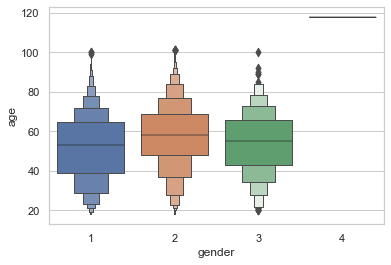

In [67]:
sns.boxenplot(data=final_df, y="age", x="gender")

mid 50 percentile of female customers are slight older than other genders

#### gender by income

<AxesSubplot:xlabel='gender', ylabel='income'>

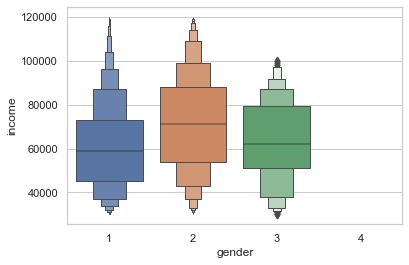

In [68]:
sns.boxenplot(data=final_df, y="income", x="gender")

female customers have higher income than others 

#### gender by membership days

<AxesSubplot:xlabel='gender', ylabel='membership_days'>

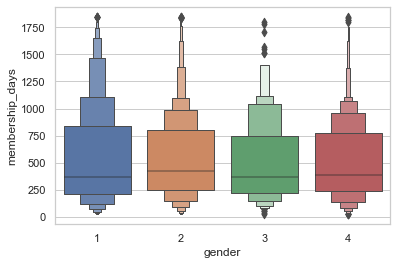

In [69]:
sns.boxenplot(data=final_df, y="membership_days", x="gender")

membership_days are similar among all genders

#### age 

In [70]:
final_df['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

<AxesSubplot:>

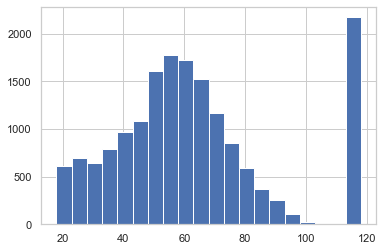

In [71]:
final_df['age'].hist(bins=20)

the distribution of age is bell shaped, and the peak is at around age 55.

#### income

In [72]:
final_df['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

<AxesSubplot:>

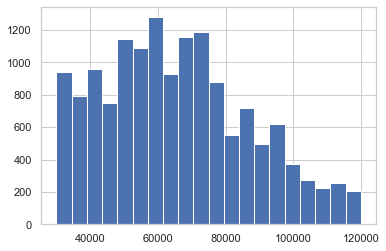

In [73]:
final_df['income'].hist(bins=20)

income of mid 50 percentile is between 49000 and 80000 

#### income by gender

<AxesSubplot:xlabel='gender', ylabel='income'>

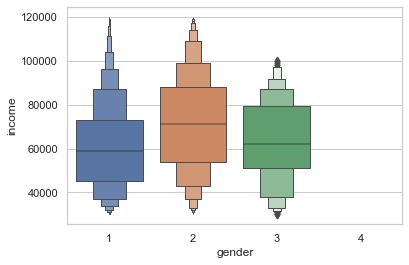

In [74]:
sns.boxenplot(x='gender', y='income', data=final_df)

Females generally have higher income than males

#### income by age

<AxesSubplot:xlabel='age', ylabel='income'>

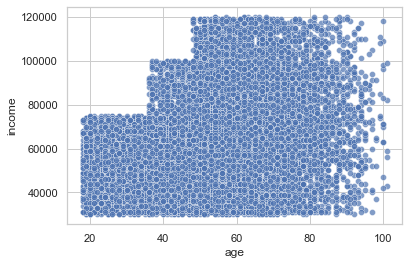

In [75]:
sns.scatterplot(x='age', y='income', data=final_df, alpha=.7)

this graph shows clear steps among different age groups
- maximum income of customers below age 40 is less than 80000 dollars
- maximum income of customers below age 50 is around 100000 dollars
- maximum income of customers above age 50 is 120000 dollars

<AxesSubplot:xlabel='age', ylabel='income'>

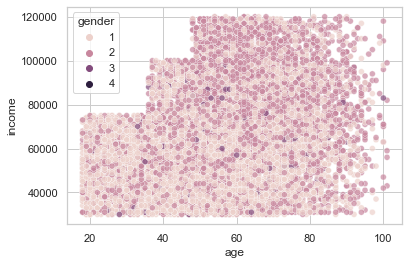

In [76]:
sns.scatterplot(x='age', y='income',hue='gender', data=final_df, alpha=.7)

more red dots are in the upright corner, and more blue dots are in the bottomleft corner

#### membership_days

In [77]:
final_df['membership_days'].describe()

count    17000.000000
mean       541.449882
std        411.223904
min         24.000000
25%        232.000000
50%        382.000000
75%        815.000000
max       1847.000000
Name: membership_days, dtype: float64

<AxesSubplot:>

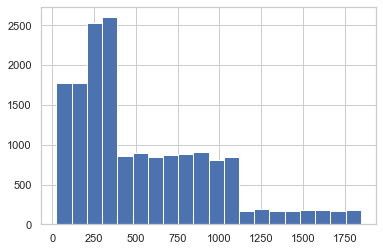

In [78]:
final_df['membership_days'].hist(bins=20)

a lot of customers have become member of this program within a year, and there are a small group of really loyal customers who have joined this program for more than 4 years.

<AxesSubplot:xlabel='gender', ylabel='membership_days'>

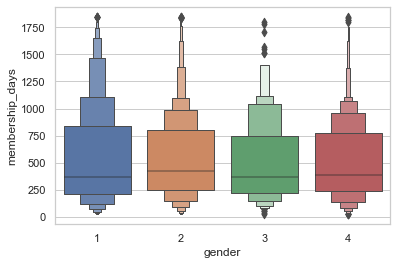

In [79]:
sns.boxenplot(x='gender', y='membership_days', data=final_df)

Membership days are almost the same among all genders

#### enrollment count by year

<AxesSubplot:xlabel='enrolled year', ylabel='count'>

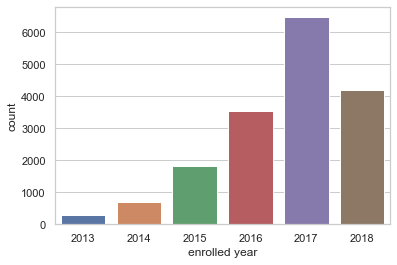

In [80]:
sns.countplot(data = final_df, x='enrolled year')

In [81]:
final_df['enrolled year'].value_counts(normalize=True).sort_index()

2013    0.016824
2014    0.040647
2015    0.107647
2016    0.207412
2017    0.380529
2018    0.246941
Name: enrolled year, dtype: float64

among all members, 38% enrolled in year 2017. since this data only contains information up to July 26th, 2018, so the data of 2018 is incomplete.

### 2. money spent

#### total amount of money spent

In [82]:
final_df.filter(regex='mamt').head()

,mamt_sum_total,mamt_mean_total,mamt_max_total,mamt_min_total,mamt_sum_bogo,mamt_sum_discount,mamt_sum_informational,mamt_mean_bogo,mamt_mean_discount,mamt_mean_informational,mamt_max_bogo,mamt_max_discount,mamt_max_informational,mamt_min_bogo,mamt_min_discount,mamt_min_informational,mamt_sum_email,mamt_mean_email,mamt_max_email,mamt_min_email,mamt_sum_mobile,mamt_mean_mobile,mamt_max_mobile,mamt_min_mobile,mamt_sum_social,mamt_mean_social,mamt_max_social,mamt_min_social,mamt_sum_web,mamt_mean_web,mamt_max_web,mamt_min_web,"mamt_sum_""offer_1""","mamt_sum_""offer_10""","mamt_sum_""offer_2""","mamt_sum_""offer_3""","mamt_sum_""offer_4""","mamt_sum_""offer_5""","mamt_sum_""offer_6""","mamt_sum_""offer_7""","mamt_sum_""offer_8""","mamt_sum_""offer_9""","mamt_mean_""offer_1""","mamt_mean_""offer_10""","mamt_mean_""offer_2""","mamt_mean_""offer_3""","mamt_mean_""offer_4""","mamt_mean_""offer_5""","mamt_mean_""offer_6""","mamt_mean_""offer_7""","mamt_mean_""offer_8""","mamt_mean_""offer_9""","mamt_max_""offer_1""","mamt_max_""offer_10""","mamt_max_""offer_2""","mamt_max_""offer_3""","mamt_max_""offer_4""","mamt_max_""offer_5""","mamt_max_""offer_6""","mamt_max_""offer_7""","mamt_max_""offer_8""","mamt_max_""offer_9""","mamt_min_""offer_1""","mamt_min_""offer_10""","mamt_min_""offer_2""","mamt_min_""offer_3""","mamt_min_""offer_4""","mamt_min_""offer_5""","mamt_min_""offer_6""","mamt_min_""offer_7""","mamt_min_""offer_8""","mamt_min_""offer_9"""
0009655768c64bdeb2e877511632db8f,127.60,15.950000,28.16,8.57,14.11,82.76,30.73,14.110000,16.5520,15.3650,14.11,28.16,22.16,14.11,10.27,8.57,127.60,15.950000,28.16,8.57,127.60,15.950000,28.16,8.57,119.03,17.004286,28.16,10.27,105.44,15.062857,28.16,8.57,NaN,NaN,NaN,8.57,NaN,NaN,NaN,82.76,22.16,14.11,NaN,NaN,NaN,8.57,NaN,NaN,NaN,16.5520,22.1600,14.110000,NaN,NaN,NaN,8.57,NaN,NaN,NaN,28.16,22.16,14.11,NaN,NaN,NaN,8.57,NaN,NaN,NaN,10.27,22.16,14.11
00116118485d4dfda04fdbaba9a87b5c,4.09,1.363333,3.19,0.20,4.09,NaN,NaN,1.363333,NaN,NaN,3.19,NaN,NaN,0.20,NaN,NaN,4.09,1.363333,3.19,0.20,4.09,1.363333,3.19,0.20,4.09,1.363333,3.19,0.20,4.09,1.363333,3.19,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.363333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20
0011e0d4e6b944f998e987f904e8c1e5,79.46,15.892000,23.03,8.96,54.04,11.93,13.49,18.013333,11.9300,13.4900,23.03,11.93,13.49,8.96,11.93,13.49,79.46,15.892000,23.03,8.96,79.46,15.892000,23.03,8.96,11.93,11.930000,11.93,11.93,79.46,15.892000,23.03,8.96,NaN,NaN,NaN,13.49,54.04,NaN,11.93,NaN,NaN,NaN,NaN,NaN,NaN,13.49,18.013333,NaN,11.9300,NaN,NaN,NaN,NaN,NaN,NaN,13.49,23.03,NaN,11.93,NaN,NaN,NaN,NaN,NaN,NaN,13.49,8.96,NaN,11.93,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,196.86,24.607500,33.86,17.24,51.10,98.33,47.43,25.550000,24.5825,23.7150,33.86,32.00,27.94,17.24,17.63,19.49,196.86,24.607500,33.86,17.24,196.86,24.607500,33.86,17.24,196.86,24.607500,33.86,17.24,149.43,24.905000,33.86,17.24,NaN,NaN,51.1,NaN,NaN,NaN,NaN,98.33,47.43,NaN,NaN,NaN,25.55,NaN,NaN,NaN,NaN,24.5825,23.7150,NaN,NaN,NaN,33.86,NaN,NaN,NaN,NaN,32.00,27.94,NaN,NaN,NaN,17.24,NaN,NaN,NaN,NaN,17.63,19.49,NaN
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.837500,20.08,6.81,32.32,46.59,58.87,10.773333,11.6475,14.7175,14.53,14.27,20.08,7.47,6.81,8.93,154.05,12.837500,20.08,6.81,154.05,12.837500,20.08,6.81,136.26,13.626000,20.08,6.81,95.18,11.897500,16.27,6.81,NaN,NaN,NaN,NaN,17.79,NaN,46.59,NaN,58.87,14.53,NaN,NaN,NaN,NaN,8.895000,NaN,11.6475,NaN,14.7175,14.530000,NaN,NaN,NaN,NaN,10.32,NaN,14.27,NaN,20.08,14.53,NaN,NaN,NaN,NaN,7.47,NaN,6.81,NaN,8.93,14.53


In [83]:
final_df['mamt_sum_total'].describe()

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
Name: mamt_sum_total, dtype: float64

<AxesSubplot:xlabel='gender', ylabel='mamt_sum_total'>

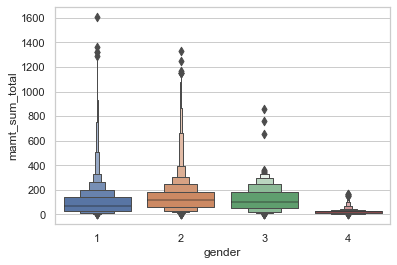

In [84]:
sns.boxenplot(x='gender', y='mamt_sum_total',data=final_df)

mysterious customers spent much less than others

### 3. offers

#### Average time to complete each offer

<AxesSubplot:xlabel='offer_type', ylabel='receive_complete_diff_mean'>

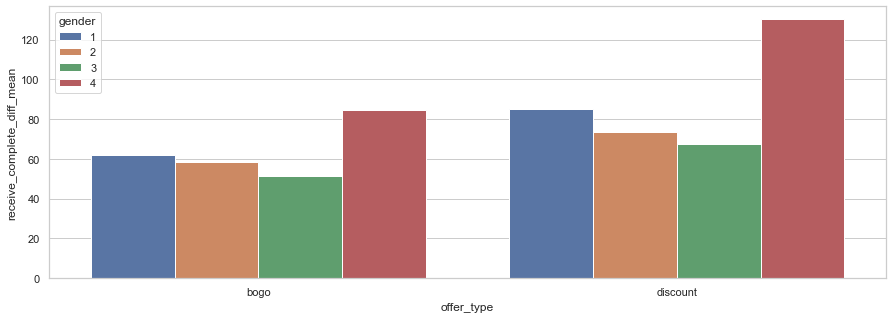

In [85]:
g_list = []
offer_types = ['bogo','discount']
for i in offer_types:
    g = final_df.groupby('gender')['receive_complete_diff_mean_%s'%i].mean().to_frame(name='receive_complete_diff_mean')
    g_list.append(g)
g_df = pd.concat(g_list, keys=offer_types).reset_index().rename(columns={'level_0':'offer_type'})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=g_df, hue='gender',y='receive_complete_diff_mean',x='offer_type')

generally it took longer time to complete discount offer than bogo offer, and customers of unknown gender spent longest time to complete both offers than other genders.

#### order view rate by gender and type

In [86]:
g_list = []
offer_types = ['bogo','discount','informational']
for i in offer_types:
    g = final_df.groupby('gender')['pct_view/receive_%s'%i].mean().to_frame(name='pct_view/receive')
    g_list.append(g)
g_df = pd.concat(g_list, keys=offer_types).reset_index().rename(columns={'level_0':'offer_type'})

<AxesSubplot:xlabel='offer_type', ylabel='pct_view/receive'>

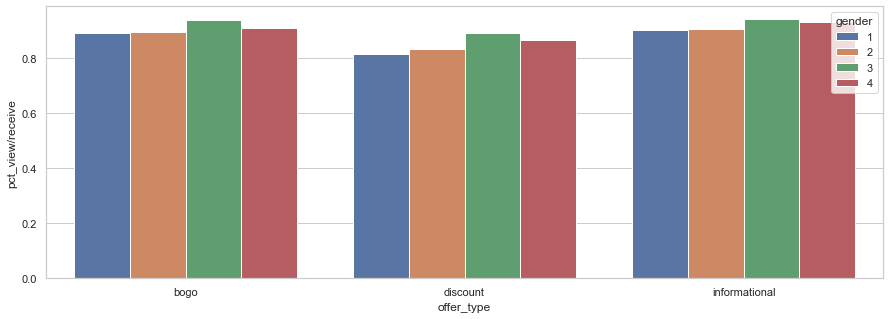

In [87]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=g_df, hue='gender',y='pct_view/receive',x='offer_type')

the ranking of attractivenees is informational, bogo, discount and for all genders, and customers of other gender have higher offer view rate for all type of offers.

#### order completion rate by gender and type

In [88]:
g_list = []
offer_types = ['bogo','discount']
for i in offer_types:
    g = final_df.groupby('gender')['pct_complete/receive_%s'%i].mean().to_frame(name='pct_complete/receive')
    g_list.append(g)
g_df = pd.concat(g_list, keys=offer_types).reset_index().rename(columns={'level_0':'offer_type'})

<AxesSubplot:xlabel='offer_type', ylabel='pct_complete/receive'>

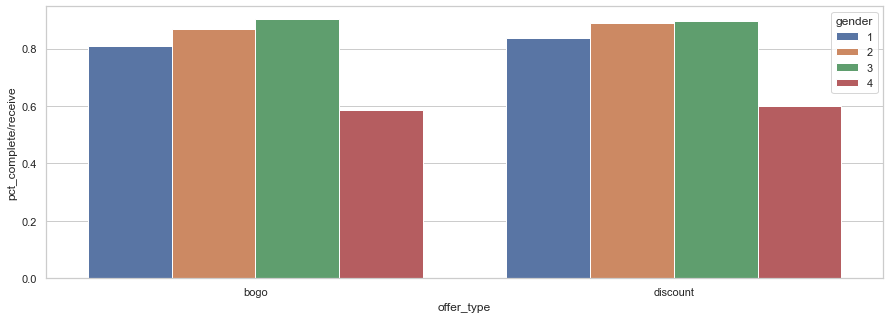

In [89]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=g_df, hue='gender',y='pct_complete/receive',x='offer_type')

completion rate distribution of bogo and discount is similar, and the rate of discount is slightly higher than bogo for male, female, and unknown gender customers

#### completion rate

In [90]:
transcript[transcript['event'].str.contains('comp')]['new_offer_id'].value_counts(dropna=False)

"offer_7"     5317
"offer_6"     5156
"offer_4"     4354
"offer_9"     4296
"offer_10"    4017
"offer_1"     3688
"offer_5"     3420
"offer_2"     3331
Name: new_offer_id, dtype: int64

There is no record of completing of offer 3 and 8 by any customer, so for this dataset offer 3 and 8 will not be recommended at all, and I will not build prediction model for these two offers.

/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='offer_id', ylabel='pct_complete/receive'>

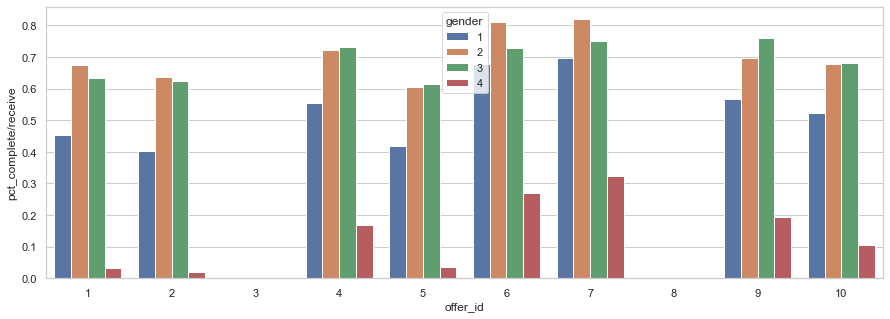

In [91]:
g_list = []
offer_ids = np.arange(1,11,1)
for i in offer_ids:
    g = final_df.groupby('gender')['cnt_complete_"offer_%d"'%i,'cnt_receive_"offer_%d"'%i].sum()
    g_pct = (g.iloc[:,0]/g.iloc[:,1]).to_frame(name='pct_complete/receive')
    g_list.append(g_pct)

g_df = pd.concat(g_list, keys=offer_ids).reset_index().rename(columns={'level_0':'offer_id'})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=g_df, hue='gender',y='pct_complete/receive',x='offer_id')

completion rate is higher for offer 6 and 7, and female customers have higher completion rate than other gender for most offers, and customers of unknown gender have lowest completion rate for all offers.

# Model

#### I will predict whether a person will complete an offer or not based on the "average complete/receive percentage", if it is greater than 0, then I will label it as Yes, and if it is 0, then No. So I will build 8 models since there are 10 different offers, and I will calculate the probability of completing each offer, and send the customer the offer with highest probability.

#### I will try different algorithms, starting with the simple ones such as Naive Bayes and Support Vector Machine, and then try ensemble algorithms such as Random Forest and CatBoost.

In [92]:
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.models.shadow_decision_tree import ShadowDecTree
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz import trees

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

final_df = pd.read_csv('final_df.csv', index_col=0)
final_df.head()

,cnt_receive_total,cnt_receive_bogo,cnt_receive_discount,cnt_receive_informational,cnt_receive_email,cnt_receive_mobile,cnt_receive_social,cnt_receive_web,"cnt_receive_""offer_10""","cnt_receive_""offer_3""","cnt_receive_""offer_7""","cnt_receive_""offer_8""","cnt_receive_""offer_9""","cnt_receive_""offer_4""","cnt_receive_""offer_5""","cnt_receive_""offer_6""","cnt_receive_""offer_1""","cnt_receive_""offer_2""",cnt_view_total,cnt_view_bogo,cnt_view_discount,cnt_view_informational,cnt_view_email,cnt_view_mobile,cnt_view_social,cnt_view_web,"cnt_view_""offer_10""","cnt_view_""offer_3""","cnt_view_""offer_7""","cnt_view_""offer_8""","cnt_view_""offer_9""","cnt_view_""offer_4""","cnt_view_""offer_5""","cnt_view_""offer_6""","cnt_view_""offer_1""","cnt_view_""offer_2""",cnt_complete_total,cnt_complete_bogo,cnt_complete_discount,cnt_complete_informational,cnt_complete_email,cnt_complete_mobile,cnt_complete_social,cnt_complete_web,"cnt_complete_""offer_10""","cnt_complete_""offer_3""","cnt_complete_""offer_7""","cnt_complete_""offer_8""","cnt_complete_""offer_9""","cnt_complete_""offer_4""","cnt_complete_""offer_5""","cnt_complete_""offer_6""","cnt_complete_""offer_1""","cnt_complete_""offer_2""",cnt_cwv_total,cnt_cwv_bogo,cnt_cwv_discount,cnt_cwv_informational,cnt_cwv_email,cnt_cwv_mobile,cnt_cwv_social,cnt_cwv_web,"cnt_cwv_""offer_10""","cnt_cwv_""offer_3""","cnt_cwv_""offer_7""","cnt_cwv_""offer_8""","cnt_cwv_""offer_9""","cnt_cwv_""offer_4""","cnt_cwv_""offer_5""","cnt_cwv_""offer_6""","cnt_cwv_""offer_1""","cnt_cwv_""offer_2""",cnt_vac_total,cnt_vac_bogo,cnt_vac_discount,cnt_vac_informational,cnt_vac_email,cnt_vac_mobile,cnt_vac_social,cnt_vac_web,"cnt_vac_""offer_10""","cnt_vac_""offer_3""","cnt_vac_""offer_7""","cnt_vac_""offer_8""","cnt_vac_""offer_9""","cnt_vac_""offer_4""","cnt_vac_""offer_5""","cnt_vac_""offer_6""","cnt_vac_""offer_1""","cnt_vac_""offer_2""",pct_view/receive_total,pct_view/receive_bogo,pct_view/receive_discount,pct_view/receive_informational,pct_view/receive_email,pct_view/receive_mobile,pct_view/receive_social,pct_view/receive_web,"pct_view/receive_""offer_10""","pct_view/receive_""offer_3""","pct_view/receive_""offer_7""","pct_view/receive_""offer_8""","pct_view/receive_""offer_9""","pct_view/receive_""offer_4""","pct_view/receive_""offer_5""","pct_view/receive_""offer_6""","pct_view/receive_""offer_1""","pct_view/receive_""offer_2""",pct_complete/receive_total,pct_complete/receive_bogo,pct_complete/receive_discount,pct_complete/receive_informational,pct_complete/receive_email,pct_complete/receive_mobile,pct_complete/receive_social,pct_complete/receive_web,"pct_complete/receive_""offer_10""","pct_complete/receive_""offer_3""","pct_complete/receive_""offer_7""","pct_complete/receive_""offer_8""","pct_complete/receive_""offer_9""","pct_complete/receive_""offer_4""","pct_complete/receive_""offer_5""","pct_complete/receive_""offer_6""","pct_complete/receive_""offer_1""","pct_complete/receive_""offer_2""",pct_cwv/complete_total,pct_cwv/complete_bogo,pct_cwv/complete_discount,pct_cwv/complete_informational,pct_cwv/complete_email,pct_cwv/complete_mobile,pct_cwv/complete_social,pct_cwv/complete_web,"pct_cwv/complete_""offer_10""","pct_cwv/complete_""offer_3""","pct_cwv/complete_""offer_7""","pct_cwv/complete_""offer_8""","pct_cwv/complete_""offer_9""","pct_cwv/complete_""offer_4""","pct_cwv/complete_""offer_5""","pct_cwv/complete_""offer_6""","pct_cwv/complete_""offer_1""","pct_cwv/complete_""offer_2""",pct_vac/view_total,pct_vac/view_bogo,pct_vac/view_discount,pct_vac/view_informational,pct_vac/view_email,pct_vac/view_mobile,pct_vac/view_social,pct_vac/view_web,"pct_vac/view_""offer_10""","pct_vac/view_""offer_3""","pct_vac/view_""offer_7""","pct_vac/view_""offer_8""","pct_vac/view_""offer_9""","pct_vac/view_""offer_4""","pct_vac/view_""offer_5""","pct_vac/view_""offer_6""","pct_vac/view_""offer_1""","pct_vac/view_""offer_2""",receive_view_diff_max_total,receive_view_diff_min_total,receive_view_diff_mean_total

In [93]:
model_df = final_df.copy()
model_df = model_df.fillna(0)
offer_ids = [1,2,4,5,6,7,9,10]

In [94]:
def over_sampling(df, offer_id):
    # Class count
    target = 'pct_complete/receive_"offer_%d"'%offer_id
    
    df[target] = np.where(df[target]==0,0,1)
    count_class_0, count_class_1 = df[target].value_counts()

    # Divide by class
    df_class_0 = df[df[target]==0]
    df_class_1 = df[df[target]>0]

    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df_over = pd.concat([df_class_1_over, df_class_0], axis=0)
    
    return df_over
    
def model(df, offer_id, algorithm):
    print('offer_%d'%offer_id)
    target = 'pct_complete/receive_"offer_%d"'%offer_id
    
    complete_columns = df.loc[:, df.columns.str.contains('complete|cwv')].columns.tolist()
    
    X = df.drop(complete_columns, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = TTS(X, y, test_size=.3)
    
    clf = algorithm.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print('Accuracy score:', accuracy_score(y_test, y_pred))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

#### Naive Bayes

offer_1
Accuracy score: 0.843501326259947


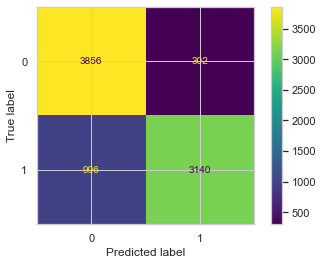

offer_2
Accuracy score: 0.8962097059865392


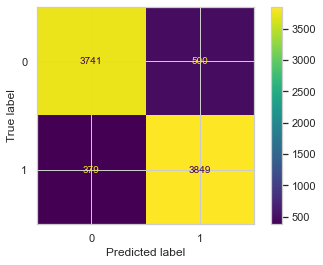

offer_4
Accuracy score: 0.794577553593947


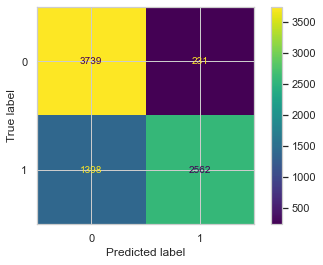

offer_5
Accuracy score: 0.7236748276681721


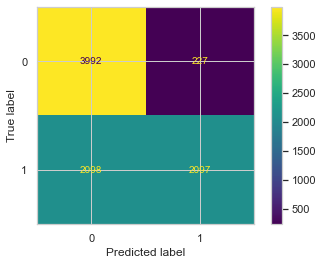

offer_6
Accuracy score: 0.8859300476947536


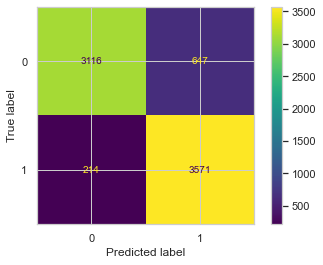

offer_7
Accuracy score: 0.91299117882919


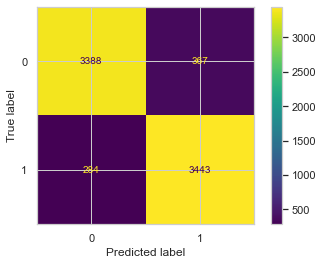

offer_9
Accuracy score: 0.8421317244846657


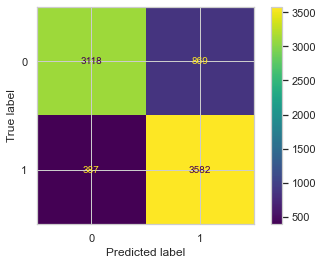

offer_10
Accuracy score: 0.7936390532544378


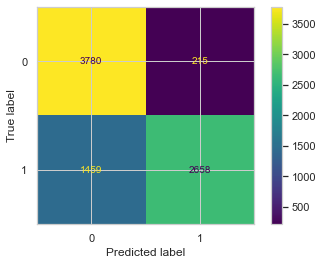

In [95]:
for i in offer_ids:
    offer_id = '"offer_%s"'%i
    df_over = over_sampling(model_df, i)
    model(df_over, i, GaussianNB())

Accuracy scores are already not very high, and number of false negative are pretty high for some models.

#### Support Vector Machine

offer_1


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score: 0.8056426332288401


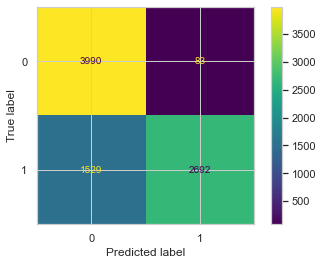

offer_2
Accuracy score: 0.8603140866690282


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


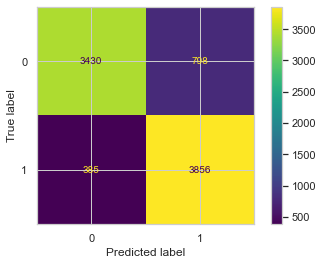

offer_4
Accuracy score: 0.7271122320302649


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


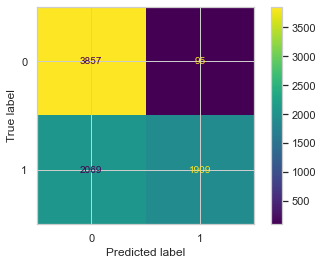

offer_5
Accuracy score: 0.7880912764440219


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


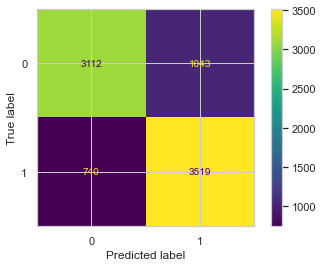

offer_6
Accuracy score: 0.8790408055113937


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


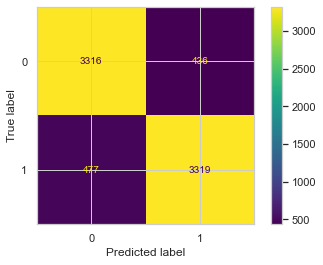

offer_7


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score: 0.8874632451216252


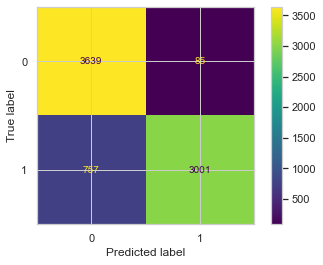

offer_9
Accuracy score: 0.899069884364002


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


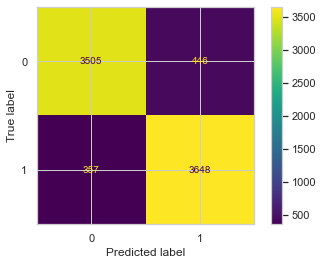

offer_10
Accuracy score: 0.7650394477317555


/Users/gaq/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


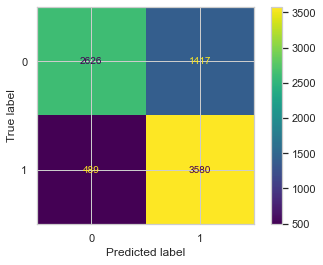

In [96]:
for i in offer_ids:
    offer_id = '"offer_%s"'%i
    
    df_over = over_sampling(model_df, i)
    
    model(df_over, i, LinearSVC())

Accuracy scores are not high as well, and number of false negative are high for model 1 and 4 and 10, while number of false positive are high for modle 7 and 9

#### K Nearest Neighbors

offer_1
Accuracy score: 0.8050397877984085


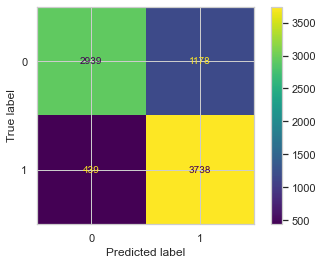

offer_2
Accuracy score: 0.8051718030464046


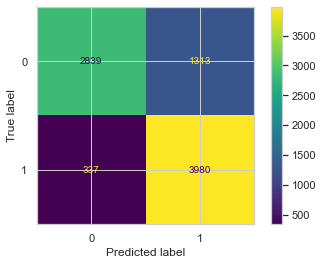

offer_4
Accuracy score: 0.7382093316519546


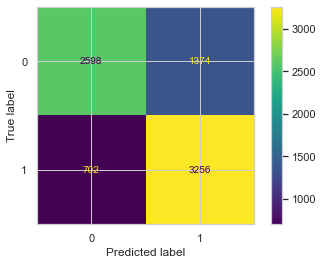

offer_5
Accuracy score: 0.7902305681007844


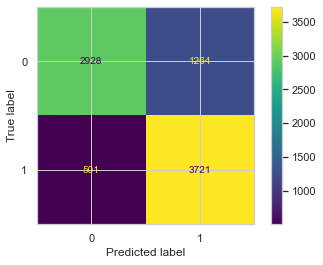

offer_6
Accuracy score: 0.7523847376788553


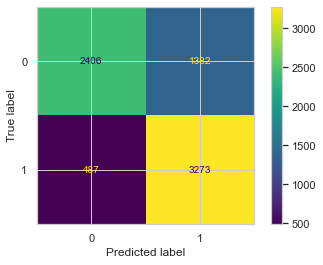

offer_7
Accuracy score: 0.776663993584603


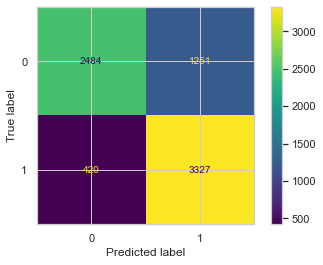

offer_9
Accuracy score: 0.751131221719457


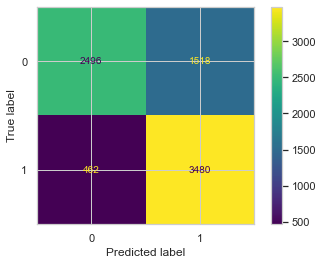

offer_10
Accuracy score: 0.7508629191321499


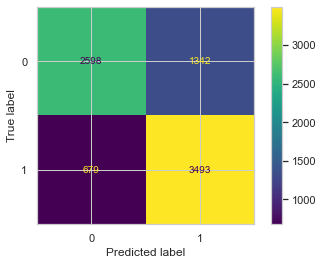

In [97]:
for i in offer_ids:
    offer_id = '"offer_%s"'%i
    
    df_over = over_sampling(model_df, i)
    
    model(df_over, i, KNeighborsClassifier())

Number of false positives are pretty high for all models here

#### Decision Tree

offer_1
Accuracy score: 0.9893899204244032


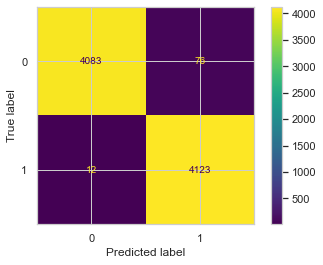

offer_2
Accuracy score: 0.9930334159877199


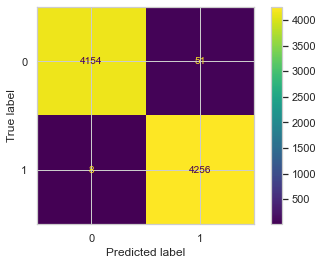

offer_4
Accuracy score: 0.9728877679697352


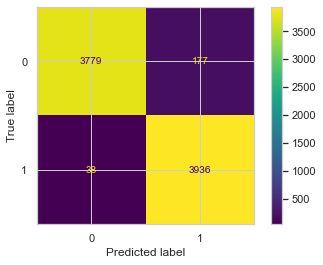

offer_5
Accuracy score: 0.9724269075350606


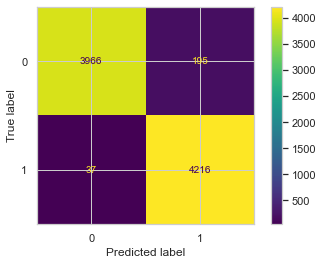

offer_6
Accuracy score: 0.9854266030736619


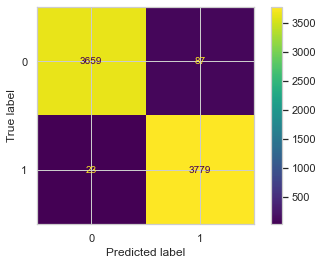

offer_7
Accuracy score: 0.9811547714514836


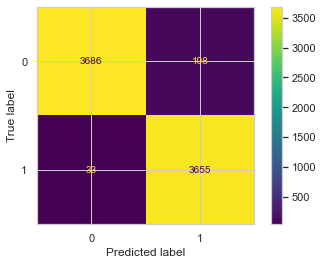

offer_9
Accuracy score: 0.9878079436902967


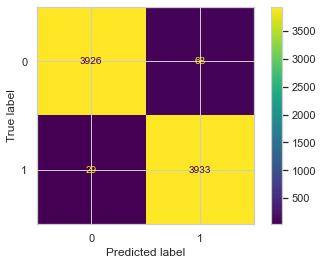

offer_10
Accuracy score: 0.971646942800789


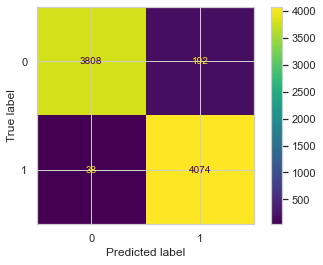

In [98]:
for i in offer_ids:
    offer_id = '"offer_%s"'%i
    
    df_over = over_sampling(model_df, i)
    
    model(df_over, i, DecisionTreeClassifier())

The scores of decision tree models are already very high, but I still will try random forest later to see if it is necessary to use ensemble methods or not.

#### Plot the tree for offer_1

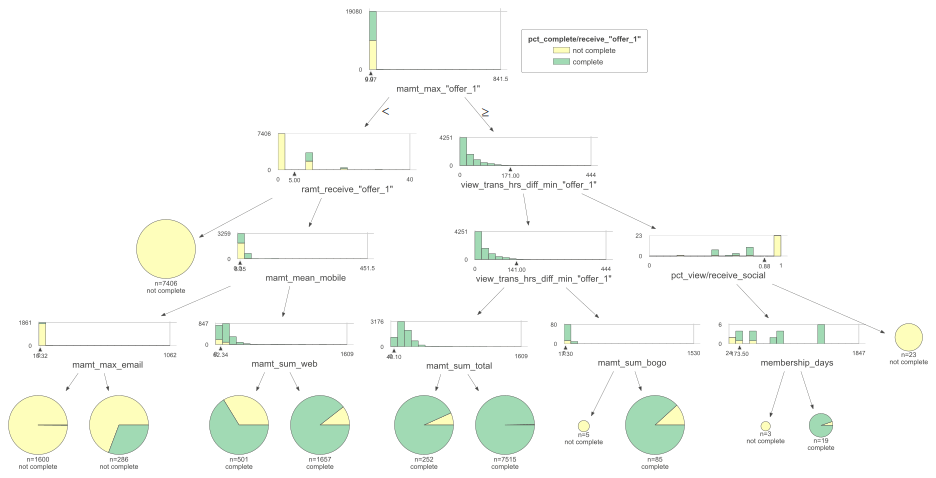

In [99]:
i = 1

df_over = over_sampling(model_df, i)

target = 'pct_complete/receive_"offer_%d"'%i

complete_columns = df_over.loc[:, model_df.columns.str.contains('complete|cwv|vac')].columns.tolist()

X = df_over.drop(complete_columns, axis=1)
y = df_over[target]

X_train, X_test, y_train, y_test = TTS(X, y, test_size=.3, random_state=723)

classifier = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)

sk_dtree = ShadowSKDTree(classifier, X_train, y_train, X_train.columns, target, ['not complete', 'complete'])

trees.dtreeviz(sk_dtree, fancy=True)

The most important features are 
- maximum amount of money spent after viewing offer_1
- amount of reward received by offer_1
- minimum time difference betweeing viewing offer_1 and making transactions

#### Random Forest

offer_1
Accuracy score: 0.9897516276826621


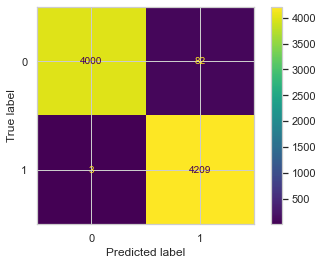

offer_2
Accuracy score: 0.992443027512103


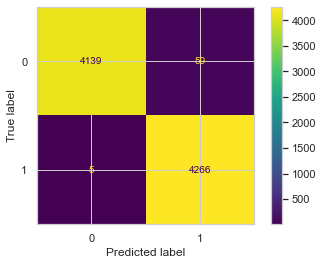

offer_4
Accuracy score: 0.9699873896595208


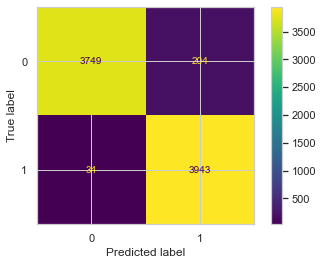

offer_5
Accuracy score: 0.9745661991918232


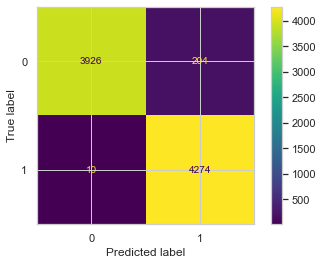

offer_6
Accuracy score: 0.9863540010598835


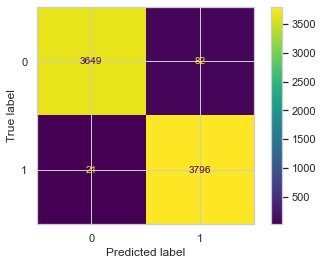

offer_7
Accuracy score: 0.98342689120556


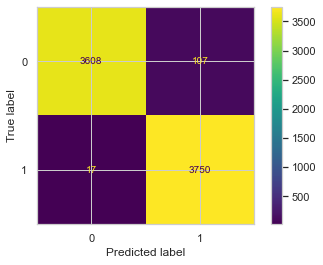

offer_9
Accuracy score: 0.9886877828054299


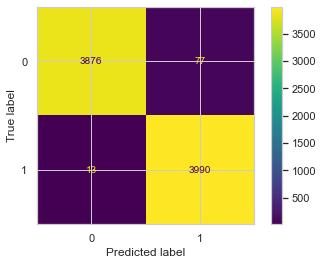

offer_10
Accuracy score: 0.9743589743589743


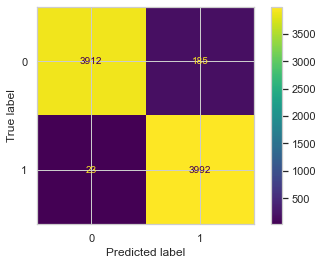

In [100]:
for i in offer_ids:
    offer_id = '"offer_%s"'%i
    
    df_over = over_sampling(model_df, i)
    
    model(df_over, i, RandomForestClassifier())

Scores, number of false negatives and false positives are almost the same as that of Decision Tree, so I will use Decision Tree as final algorithm.